In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold,cross_val_score
from sklearn.metrics import roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC,NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,VotingClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
import shap
import joblib
import warnings
warnings.filterwarnings('ignore')

/home/cfchio/miniconda3/envs/sk132/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sklearn
sklearn.show_versions()


System:
    python: 3.11.11 (main, Dec 11 2024, 16:28:39) [GCC 11.2.0]
executable: /home/cfchio/miniconda3/envs/sk132/bin/python
   machine: Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.36

Python dependencies:
      sklearn: 1.3.2
          pip: 25.1
   setuptools: 78.1.1
        numpy: 1.26.4
        scipy: 1.15.3
       Cython: None
       pandas: 2.2.2
   matplotlib: 3.9.1
       joblib: 1.4.2
threadpoolctl: 3.6.0

Built with OpenMP: True

threadpoolctl info:
       user_api: blas
   internal_api: openblas
    num_threads: 20
         prefix: libopenblas
       filepath: /home/cfchio/miniconda3/envs/sk132/lib/python3.11/site-packages/numpy.libs/libopenblas64_p-r0-0cf96a72.3.23.dev.so
        version: 0.3.23.dev
threading_layer: pthreads
   architecture: Haswell

       user_api: blas
   internal_api: openblas
    num_threads: 20
         prefix: libscipy_openblas
       filepath: /home/cfchio/miniconda3/envs/sk132/lib/python3.11/site-packages/scipy.libs/libscipy_ope

In [3]:
df = pd.read_csv('./chcsj_train_balanced_up.csv')

In [4]:
# Features selected by LASSO
feature_names = ['Age','Menopause','US1','US2','US5','US6','US7','CA125','BUN','ALT','AAR','WBC','Lym','PLR']

x_train = df[feature_names]
y_train = df['Type_ID']
train_mean = df.mean(axis=0, numeric_only=True)

In [5]:
x_train.describe()

Age   Menopause         US1         US2         US5         US6  \
count  560.000000  560.000000  560.000000  560.000000  560.000000  560.000000   
mean    46.882143    0.366071    0.323214    0.607143    0.039286    0.628571   
std     14.258426    0.482160    0.468122    0.488822    0.194448    0.483619   
min     12.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%     35.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%     48.000000    0.000000    0.000000    1.000000    0.000000    1.000000   
75%     58.000000    1.000000    1.000000    1.000000    0.000000    1.000000   
max     84.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

              US7        CA125         BUN         ALT         AAR  \
count  560.000000   560.000000  557.000000  556.000000  556.000000   
mean     0.085714   322.584464    4.065530   14.991007    1.420399   
std      0.280192   803.184027    1.555299   10.265218    0.537535   
min      0.000000     4.400000    1.600000    3.000000    0.468750   
25%      0.000000    17.300000    3.200000   10.000000    1.000000   
50%      0.000000    43.300000    3.800000   13.000000    1.333333   
75%      0.000000   157.000000    4.600000   17.000000    1.692308   
max      1.000000  7582.000000   21.600000  140.000000    3.400000   

              WBC         Lym         PLR  
count  560.000000  560.000000  560.000000  
mean     7.382500    1.722857  195.561712  
std      3.306022    0.575541  120.376757  
min      2.600000    0.200000   59.090909  
25%      5.300000    1.300000  127.969697  
50%      6.500000    1.600000  162.000000  
75%      8.300000    2.100000  210.000000  
max     27.500000    3.800000  828.750000

In [6]:
for i in x_train.columns:
  x_train[i].fillna(x_train[i].mean(), inplace=True)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)

In [7]:
params = {}
params['lr'] = {'C':10, 'solver':'liblinear', 'random_state':2024}
params['knn'] = {'n_neighbors':6}
params['svc'] = {'C':5, 'decision_function_shape':'ovo', 'degree':2, 'kernel':'linear', 'probability':True, 'random_state':2024}
params['nsvc'] = {'degree':2, 'decision_function_shape':'ovo', 'kernel':'linear', 'nu':0.6, 'probability':True, 'random_state':2024}
params['dtc'] = {'criterion':'entropy', 'max_depth':4, 'max_leaf_nodes':5, 'max_features':'sqrt', 'random_state':2024}
params['rfc'] = {'criterion':'entropy', 'max_depth':5, 'max_leaf_nodes':6, 'n_estimators':100, 'max_features':'sqrt',
                       'random_state':2024}
params['abc'] = {'estimator':DecisionTreeClassifier(**params['dtc']), 'learning_rate':1, 'n_estimators':100, 'random_state':2024}
params['xgb'] = {'n_estimators':25, 'max_depth':3, 'learning_rate':0.1, 'objective':'binary:logistic', 'random_state':2024}
params['lgb'] = {'max_depth':4, 'n_estimators':50, 'objective':'binary', 'verbose':-100, 'random_state':2024}

LogisticRegression: 0.934 +/- 0.034 (0.870-0.972)
KNeighbors: 0.920 +/- 0.023 (0.871-0.961)
SVC: 0.932 +/- 0.033 (0.867-0.974)
NuSVC: 0.913 +/- 0.037 (0.853-0.959)
DecisionTree: 0.833 +/- 0.057 (0.708-0.934)
RandomForest: 0.932 +/- 0.034 (0.856-0.974)
AdaBoost: 0.958 +/- 0.019 (0.920-0.983)
XGB: 0.945 +/- 0.036 (0.867-0.992)
LGBM: 0.955 +/- 0.033 (0.878-0.997)
Voting: 0.950 +/- 0.024 (0.916-0.980)


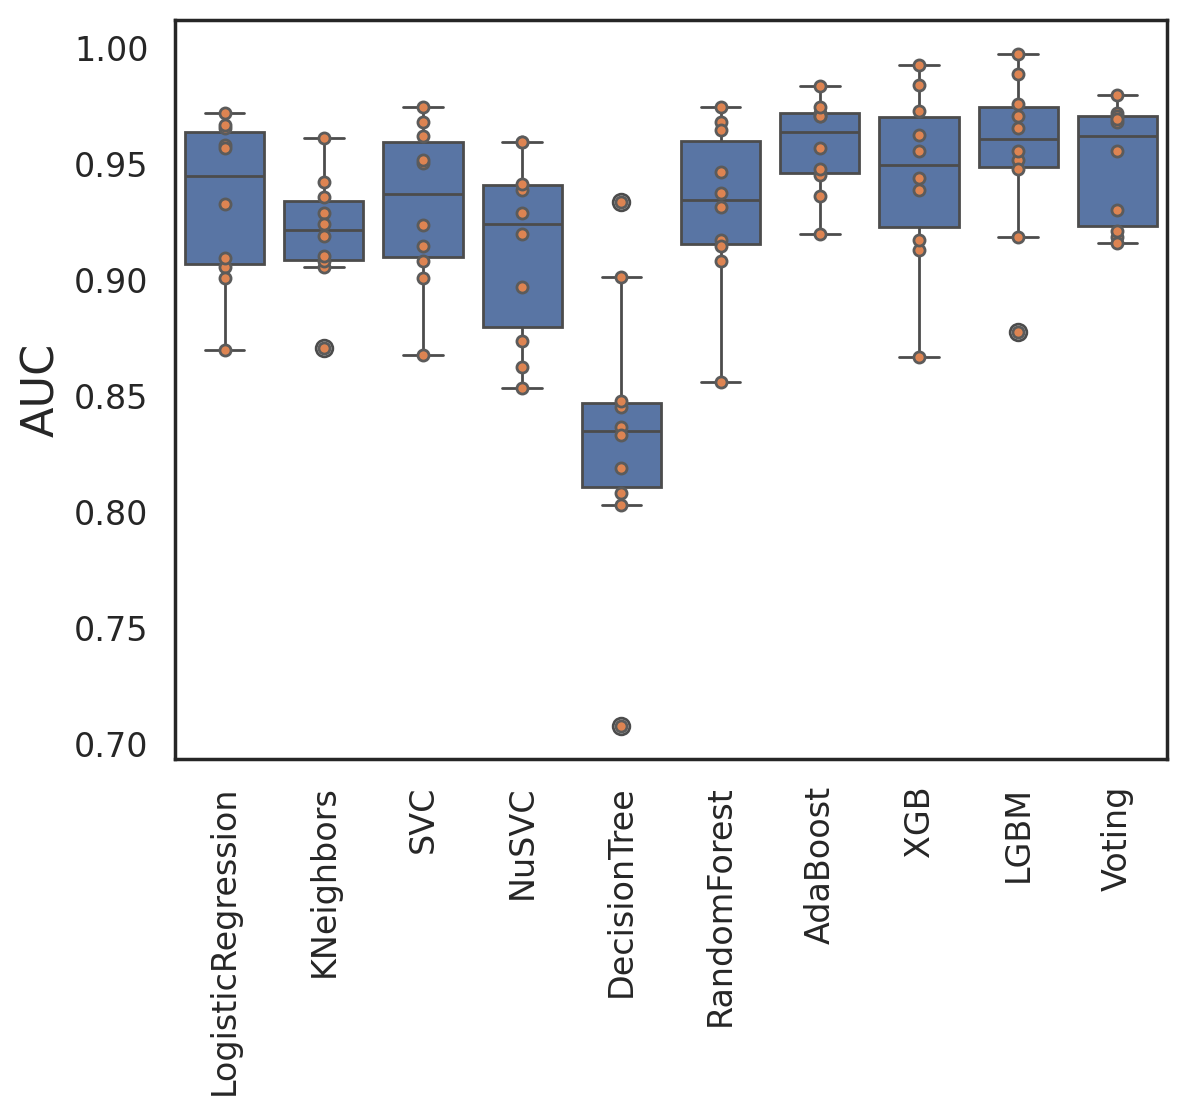

In [8]:
models = [  LogisticRegression(**params['lr']),
            KNeighborsClassifier(**params['knn']),
            SVC(**params['svc']),
            NuSVC(**params['nsvc']),
            DecisionTreeClassifier(**params['dtc']),
            RandomForestClassifier(**params['rfc']),
            AdaBoostClassifier(**params['abc']),
            XGBClassifier(**params['xgb']),
            lgb.LGBMClassifier(**params['lgb']),
            VotingClassifier([('lr', LogisticRegression(**params['lr'])),
                              ('knn', KNeighborsClassifier(**params['knn'])),
                              ('svc', SVC(**params['svc'])),
                              ('rfc', RandomForestClassifier(**params['rfc'])),
                              ('abc', AdaBoostClassifier(**params['abc']))],
                              voting='soft')
          ]
CV = 10
skf = StratifiedKFold(n_splits=CV, random_state=42, shuffle=True)
entries = []
for model in models:
  model_name = model.__class__.__name__.replace('Classifier', '')
  aurocs = cross_val_score(model, x_train, y_train, scoring='roc_auc', cv=skf)
  print("%s: %0.3f +/- %0.3f (%0.3f-%0.3f)" % (model_name, aurocs.mean(), aurocs.std(), aurocs.min(), aurocs.max()))
  for fold_idx, auroc in enumerate(aurocs):
    entries.append((model_name, fold_idx, auroc))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'auroc'])

sns.set_theme(style="white", rc={"figure.dpi": 200})
ax = sns.boxplot(x='model_name', y='auroc', data=cv_df)
sns.stripplot(x='model_name', y='auroc', data=cv_df,
              size=4, jitter=False, edgecolor="gray", linewidth=1)

ax.set_xlabel('')
ax.set_ylabel('AUC', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xticks(rotation=90)
plt.show(ax)

In [9]:
vot = VotingClassifier([('lr', LogisticRegression(**params['lr'])),
                        ('knn', KNeighborsClassifier(**params['knn'])),
                        ('svc', SVC(**params['svc'])),
                        ('rfc', RandomForestClassifier(**params['rfc'])),
                        ('abc', AdaBoostClassifier(**params['abc']))],
                        voting='soft')

vot.fit(x_train,y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=10, random_state=2024,
                                                 solver='liblinear')),
                             ('knn', KNeighborsClassifier(n_neighbors=6)),
                             ('svc',
                              SVC(C=5, decision_function_shape='ovo', degree=2,
                                  kernel='linear', probability=True,
                                  random_state=2024)),
                             ('rfc',
                              RandomForestClassifier(criterion='entropy',
                                                     max_depth=5,
                                                     max_leaf_nodes=6,
                                                     random_state=2024)),
                             ('abc',
                              AdaBoostClassifier(estimator=DecisionTreeClassifier(criterion='entropy',
                                                                                  max_depth=4,
                                                                                  max_features='sqrt',
                                                                                  max_leaf_nodes=5,
                                                                                  random_state=2024),
                                                 learning_rate=1,
                                                 n_estimators=100,
                                                 random_state=2024))],
                 voting='soft')

In [10]:
#==== Determine cutoff on evaluation data ====
dft = pd.read_csv('./chcsj_test.csv')
dfp = pd.read_csv('./chcsj_2024.csv')
dfe = pd.read_csv('./kwh_ext.csv')
dfa = pd.concat([dft, dfp, dfe])
x_all = dfa[feature_names]
y_all = dfa['Type_ID']

for i in x_all.columns:
  x_all[i].fillna(train_mean[i], inplace=True)

x_all = scaler.transform(x_all)

proba_all = vot.predict_proba(x_all)
fpr, tpr, thresholds = roc_curve(y_all, proba_all[:,1])
j_scores = tpr - fpr
idx = np.argmax(j_scores)
train_mean['cutoff'] = thresholds[idx]
print(f"cutoff = {thresholds[idx]}")
print(f"Youden = {j_scores[idx]}")

cutoff = 0.5999315028227254
Youden = 0.7657004830917874


In [13]:
#SHAP
x_train_k = shap.kmeans(x_train, 100)
explainer = shap.KernelExplainer(vot.predict_proba, x_train_k, link="logit")

In [ ]:
#Export scaler, model and explainer
model_name = '23-01-sk132'
joblib.dump(scaler, './mo-ovary-'+model_name+'-scaler.jb')
joblib.dump(vot, './mo-ovary-'+model_name+'-vot.jb')
joblib.dump(explainer, './mo-ovary-'+model_name+'-shap.jb')
joblib.dump(train_mean, './mo-ovary-'+model_name+'-mean.jb')

['./mo-ovary-23-03-sk132-mean.jb']

ROC curves on all unseen data

In [11]:
dft = pd.read_csv('./chcsj_test.csv')
dfp = pd.read_csv('./chcsj_2024.csv')
dfe = pd.read_csv('./kwh_ext.csv')
dfa = pd.concat([dft, dfp, dfe])
x_all = dfa[feature_names]
y_all = dfa['Type_ID']

model_name = '23-01-sk132'
train_mean = joblib.load('./mo-ovary-'+model_name+'-mean.jb')
scaler = joblib.load('./mo-ovary-'+model_name+'-scaler.jb')

for i in x_all.columns:
  x_all[i].fillna(train_mean[i], inplace=True)

x_all = scaler.transform(x_all)

LogisticRegression
cutoff = 0.33647110529374036
Youden = 0.7318840579710144
              precision    recall  f1-score   support

           0       0.96      0.82      0.88       184
           1       0.66      0.92      0.77        72

    accuracy                           0.84       256
   macro avg       0.81      0.87      0.82       256
weighted avg       0.88      0.84      0.85       256

TP=66/TN=150/FP=34/FN=6
Sen = 0.917
Spec = 0.815
PPV = 0.660
NPV = 0.962
Macro F1 = 0.825
Acc = 0.844
AUC = 0.934

KNeighbors
cutoff = 0.5
Youden = 0.7053140096618358
              precision    recall  f1-score   support

           0       0.97      0.76      0.85       184
           1       0.61      0.94      0.74        72

    accuracy                           0.81       256
   macro avg       0.79      0.85      0.80       256
weighted avg       0.87      0.81      0.82       256

TP=68/TN=140/FP=44/FN=4
Sen = 0.944
Spec = 0.761
PPV = 0.607
NPV = 0.972
Macro F1 = 0.796
Acc = 0.812
A

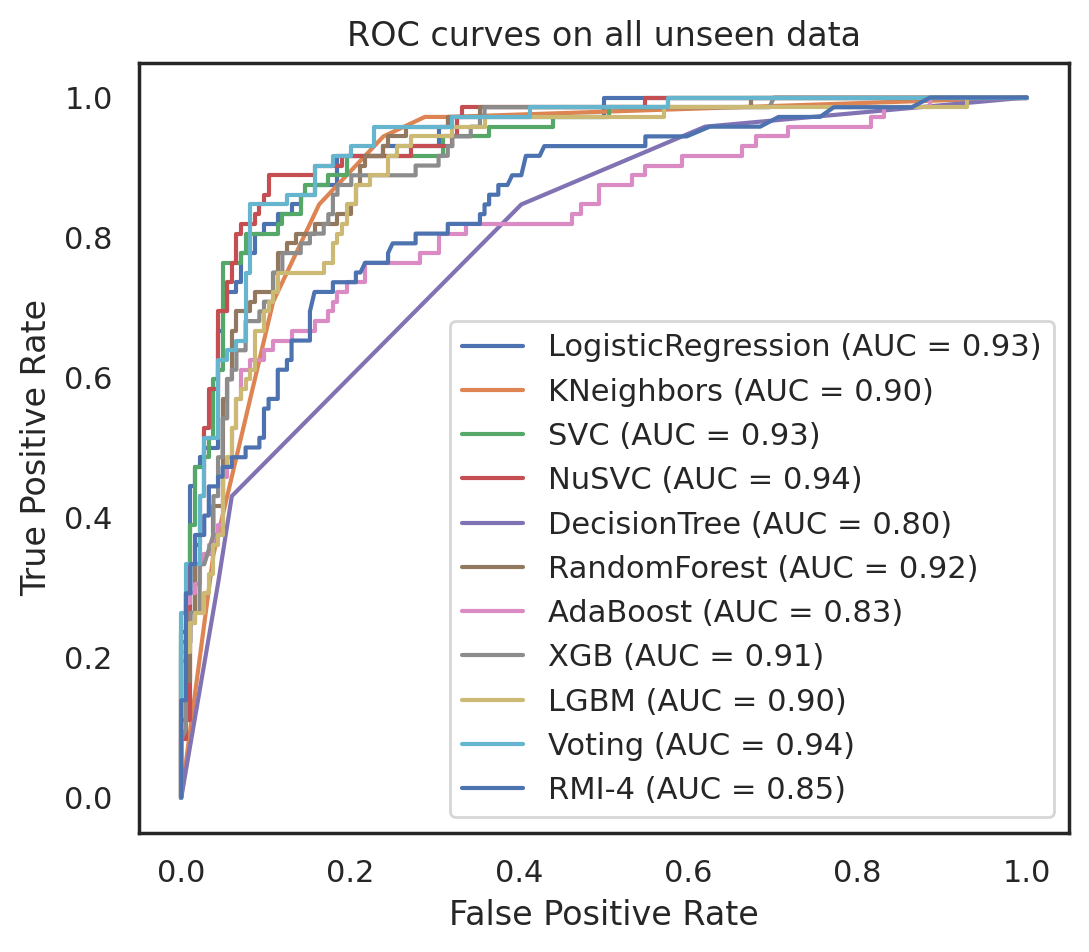

In [12]:
from sklearn import metrics
from sklearn.metrics import RocCurveDisplay,roc_curve,classification_report

models = [  LogisticRegression(**params['lr']),
            KNeighborsClassifier(**params['knn']),
            SVC(**params['svc']),
            NuSVC(**params['nsvc']),
            DecisionTreeClassifier(**params['dtc']),
            RandomForestClassifier(**params['rfc']),
            AdaBoostClassifier(**params['abc']),
            XGBClassifier(**params['xgb']),
            lgb.LGBMClassifier(**params['lgb']),
            VotingClassifier([('lr', LogisticRegression(**params['lr'])),
                              ('knn', KNeighborsClassifier(**params['knn'])),
                              ('svc', SVC(**params['svc'])),
                              ('rfc', RandomForestClassifier(**params['rfc'])),
                              ('abc', AdaBoostClassifier(**params['abc']))],
                              voting='soft')
          ]

fig, ax = plt.subplots(figsize=(6,5))
fig.set_dpi(200)

entries = []
for model in models:
  model_name = model.__class__.__name__.replace('Classifier', '')
  model.fit(x_train,y_train)
  proba_ = model.predict_proba(x_all)

  print(model_name)
  fpr, tpr, thresholds = roc_curve(y_all, proba_[:,1])
  j_scores = tpr - fpr
  idx = np.argmax(j_scores)
  print(f"cutoff = {thresholds[idx]}")
  print(f"Youden = {j_scores[idx]}")
  cutoff = thresholds[idx]
  pred_ = list(map((lambda a: 1 if a[1]>=cutoff else 0), proba_))
  print(classification_report(y_all, pred_))
  tn, fp, fn, tp = metrics.confusion_matrix(y_all, pred_).ravel()
  print(f'TP={tp}/TN={tn}/FP={fp}/FN={fn}')
  print('Sen = %.3f' % (tp / (tp + fn)))
  print('Spec = %.3f' % (tn / (tn + fp)))
  print('PPV = %.3f' % (tp / (tp + fp)))
  print('NPV = %.3f' % (tn / (tn + fn)))
  print('Macro F1 = %.3f' % metrics.f1_score(y_all, pred_, average="macro"))
  print('Acc = %.3f' % metrics.accuracy_score(y_all, pred_))
  print('AUC = %.3f' % metrics.roc_auc_score(y_all, proba_[:,1]))
  print()

  RocCurveDisplay.from_predictions(y_all, proba_[:,1], name=model_name, ax = ax, plot_chance_level=False)

RocCurveDisplay.from_predictions(y_all, dfa['RMI4'], name=f"RMI-4", ax = ax)

_ = ax.set(xlabel="False Positive Rate",
            ylabel="True Positive Rate",
            title="ROC curves on all unseen data")

plt.show(ax)